In [72]:
import numpy as np
import tensorflow as tf
import os
import cv2
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import optimizers

In [107]:
# Constants
DATASET_PATH = "dataset"
IMAGE_SIZE = (128,128)
BATCH_SIZE = 32
CLASS_NAMES = ["fire", "nonfire"]
EPOCHS=50

In [74]:
# Load the data
image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.3, 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_images = image_gen.flow_from_directory(
    directory=DATASET_PATH,
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba",
    subset="training"
)

validation_images = image_gen.flow_from_directory(
    directory=DATASET_PATH,
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=BATCH_SIZE,
    color_mode="rgba",
    subset="validation"
)

print(train_images.samples)

Found 1836 images belonging to 2 classes.
Found 785 images belonging to 2 classes.
1836


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


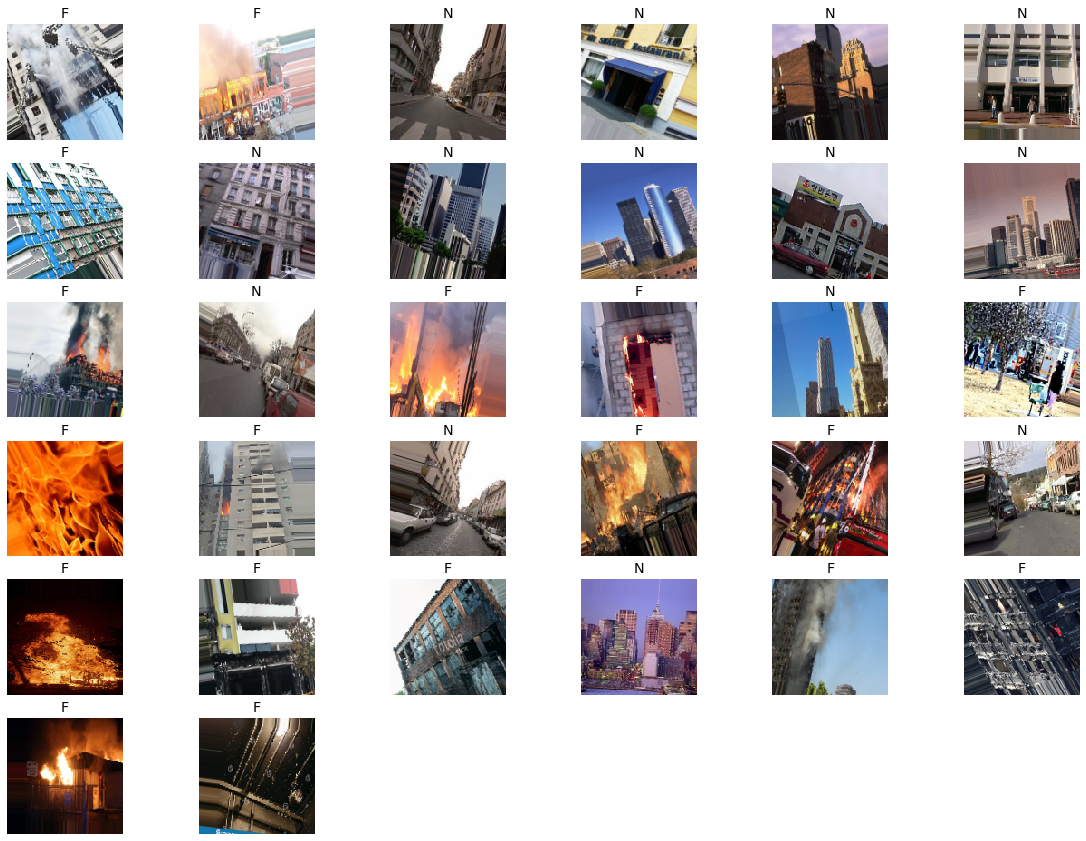

In [89]:
def show_batch(image_batch, label_batch, answers=None):
  plt.figure(figsize=(20,20))
  for n in range(len(image_batch)):
      ax = plt.subplot(8, 6,n+1)
      plt.imshow(image_batch[n])
      plt.title(f'{CLASS_NAMES[label_batch[n]==1][0].title()}{answers[n] if answers is not None else ""}')
      plt.axis('off')
        
# Display the first batch        
image_batch, label_batch = next(train_images)
show_batch(image_batch, label_batch)

In [76]:
print(f'Loaded {BATCH_SIZE * (len(train_images) - 1) + len(train_images[len(train_images) - 1][0])} images')
print(f'Created {len(train_images)} batches')

Loaded 1836 images
Created 58 batches


In [77]:
class CNN:
    def __init__(self):
        self.model = Sequential()
        self.input_shape = IMAGE_SIZE + (3,)
        chanDim = -1
        
        #CONV => RELU => POOL
        self.model.add(SeparableConv2D(32, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # (CONV => RELU) * 2 => POOL
        self.model.add(SeparableConv2D(64, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(SeparableConv2D(64, (3, 3), padding="same"))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization(axis=chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of FC => RELU layers
        self.model.add(Flatten())
        self.model.add(Dense(128))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        # second set of FC => RELU layers
        self.model.add(Dense(128))
        self.model.add(Activation("relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        self.model.add(Dense(1, activation="sigmoid"))
        
        opt = optimizers.SGD(learning_rate=1e-4)
        
        self.model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

cnn = CNN()

In [108]:
MODEL_SAVE_PATH='e50_lr-4_v30_s128.h5'

In [103]:
#Load model (uncomment this when training below)
#cnn.model = tf.keras.models.load_model(MODEL_SAVE_PATH)

In [109]:
def train():
    H = cnn.model.fit_generator(
        train_images,
        steps_per_epoch=train_images.samples // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data = validation_images, 
        validation_steps = validation_images.samples // BATCH_SIZE
    )
    
train()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 57 steps, validate for 24 steps
Epoch 1/50
57/57 [==============================] - 67s 1s/step - loss: 0.9428 - accuracy: 0.5582 - val_loss: 0.7034 - val_accuracy: 0.4609
Epoch 2/50
57/57 [==============================] - 69s 1s/step - loss: 0.9112 - accuracy: 0.5787 - val_loss: 0.6923 - val_accuracy: 0.5273
Epoch 3/50
57/57 [==============================] - 69s 1s/step - loss: 0.8830 - accuracy: 0.5809 - val_loss: 0.6944 - val_accuracy: 0.5391
Epoch 4/50
57/57 [==============================] - 72s 1s/step - loss: 0.8816 - accuracy: 0.5876 - val_loss: 0.7268 - val_accuracy: 0.5391
Epoch 5/50
57/57 [==============================] - 69s 1s/step - loss: 0.8371 - accuracy: 0.6086 - val_loss: 0.7533 - val_accuracy: 0.5391
Epoch 6/50
57/57 [==============================] - 70s 1s/step - loss: 0.8048 - accuracy: 0.6197 - val_loss: 0.7591 - val_accuracy: 0.5391
Epoch 7/50
57/57 [==============================] - 69s 1s/step - lo

In [94]:
# Save model
cnn.model.save('e50_lr-4_v30_s128.h5')

{'loss': [0.9054793952045314, 0.830559435678427, 0.8209483470197791, 0.7931503286118518, 0.792245677728082, 0.7446020433220789, 0.724391380725573, 0.7182697863906556, 0.7398993976893288, 0.7383728244087913], 'accuracy': [0.5343681, 0.5997783, 0.6125277, 0.6141907, 0.6169623, 0.64689577, 0.66186255, 0.6552106, 0.6563193, 0.65354764], 'val_loss': [0.7287816554307938, 0.7719602932532629, 0.7965672214825948, 0.7999506915609041, 0.7856596931815147, 0.7837111949920654, 0.7657463078697523, 0.7679473782579104, 0.7274102618296941, 0.6662334464490414], 'val_accuracy': [0.4609375, 0.4609375, 0.4609375, 0.4609375, 0.4609375, 0.4609375, 0.4622396, 0.4752604, 0.5442708, 0.58203125]}


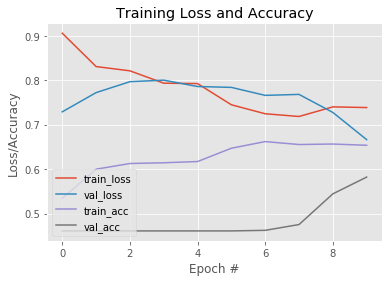

In [79]:
print(H.history)
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(config.TRAINING_PLOT_PATH)

Found 24 images belonging to 2 classes.
[['fire']
 ['fire']
 ['fire']
 ['fire']
 ['nonfire']
 ['nonfire']
 ['nonfire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['nonfire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']
 ['fire']]


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]]
13
accuracy 0.5416666666666666


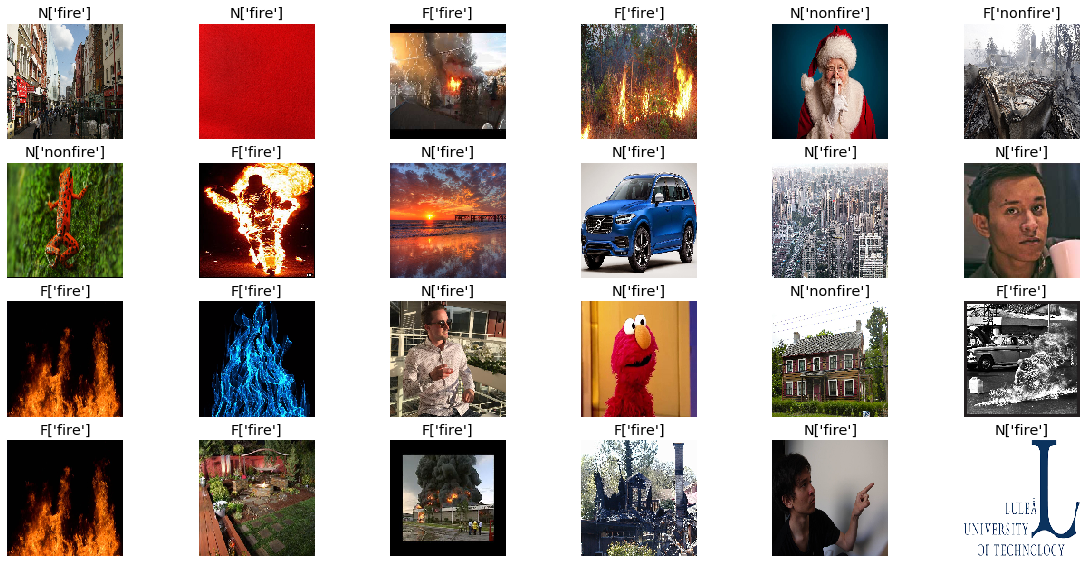

In [140]:
test_gen = ImageDataGenerator(rescale=1./255)
 
test_images = test_gen.flow_from_directory(
    "test",
    target_size=IMAGE_SIZE,
    color_mode="rgba",
    class_mode="binary"
)

images, labels = next(test_images)

predictions = cnn.model.predict(
    test_images
)

#print(predictions)

answers = np.where(predictions < 0.5, "fire", "nonfire")

print(answers)
show_batch(images, labels, answers)
matches = np.equal(np.array(labels).reshape(len(labels), 1), np.where(predictions < 0.5, 0, 1))
print(matches)
print(np.count_nonzero(matches))
print(f'accuracy {np.count_nonzero(matches) / len(matches)}')
#print(np.where(predictions < 0.5, 1, 0))
#print(np.equal(np.array(labels), np.where(predictions < 0.5, 1, 0)))
#print(f'accuracy: {labels == })